In [3]:
import numpy as np
import matplotlib.patches as patches
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib
matplotlib.use('nbagg')

In [4]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug  # ここにロボットなどのオブジェクトを登録
        self.time_span = time_span
        self.time_interval = time_interval

    def append(self, obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):
        fig = plt.figure(figsize=(4, 4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5, 5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5, 5)                              # Y軸も同様に
        ax.set_xlabel("X", fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y", fontsize=10)                 # 同じくY軸に

        elems = []
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(
                elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()

    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t = %2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

In [5]:
class IdealRobot:
    def __init__(self, pose, agent=None, color="black"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]

    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x+self.r*math.cos(theta)
        yn = y+self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r,
                           fill=False, color=self.color)
        elems.append(ax.add_patch(c))

        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1]
                                                      for e in self.poses], linewidth=0.5, color="black")

    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose+np.array([nu*math.cos(t0), nu*math.sin(t0), omega])*time
        else:
            return pose+np.array([nu/omega*(math.sin(t0+omega*time) - math.sin(t0)),
                                  nu/omega *
                                  (-math.cos(t0+omega*time) + math.cos(t0)),
                                  omega*time])

    def one_step(self, time_interval):
        if not self.agent:
            return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [6]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega

    def decision(self, observation=None):
        return self.nu, self.omega

In [12]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None

    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100,
                       marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(
            ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))

In [8]:
class Map:
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self,landmark):
        landmark.id = len(self.landmarks)
        self.landmarks.append(landmark)
        
    def draw(self,ax,elems):
        for lm in self.landmarks:lm.draw(ax,elems)

In [17]:
class IdealCamera:
    def __init__(self,env_map):
        self.map=env_map
        
    def data(self,cam_pose):
        observed=[]
        for lm in self.map.landmarks:
            p=self.observation_function(cam_pose,lm.pos)
            observed.append((p,lm.id))            
        return observed
    
    @classmethod
    def observation_function(cls,cam_pose,obj_pos):
        diff=obj_pos - cam_pose[0:2]
        phi=math.atan2(diff[1],diff[0])- cam_pose[2]
        while phi>=np.pi:phi-= 2*np.pi
        while phi < -np.pi:phi += 2*np.pi
        return np.array([np.hypot(*diff),phi]).T

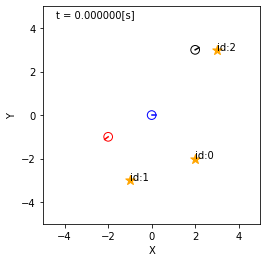

In [13]:
world = World(10,1)  # fig:class_world3

m=Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, color="red")
robot3 = IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

In [18]:
cam = IdealCamera(m)
p = cam.data(robot2.pose)
print(p)

[(array([4.24073239, 2.13237277]), 0), (array([2.19481618, 1.31984216]), 1), (array([6.60270893, 3.01471742]), 2)]


<IPython.core.display.Javascript object>


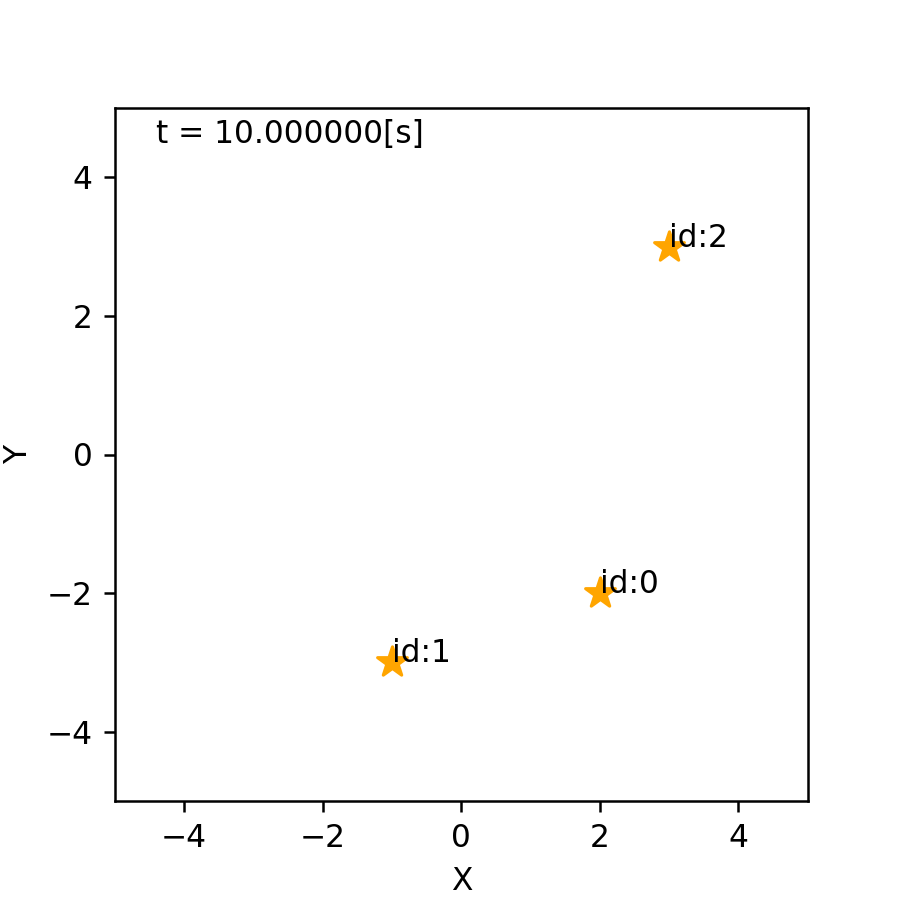

In [9]:
world = World(10,0.1)  # fig:class_world3

world.draw()